In [1]:
import dynamiqs as dq
from dynamiqs import QArray
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from CoupledQuantumSystems import TransmonOscillatorSystem
from CoupledQuantumSystems import DriveTerm, square_pulse_with_rise_fall_envelope
import scqubits
import qutip
from IPython.display import clear_output
import matplotlib.pyplot as plt

dq.set_progress_meter(True)
dq.set_device('gpu')
dq.set_precision('double')

In [ ]:
tlist = np.linspace(0,10,21)
max_ql = 10
max_ol = 50

ncut = 110

tmon_EJ = 22
tmon_EC = 0.3
tmon_ng = 0.3
Er = 14
g = 0.6
kappa = 0.022
qbt = scqubits.Transmon(EJ=tmon_EJ, EC=tmon_EC, ng=tmon_ng,ncut=ncut,truncated_dim=max_ql)
osc = scqubits.Oscillator(E_osc=Er, truncated_dim=max_ol, l_osc=1.0)

system  =  TransmonOscillatorSystem(
            qbt = qbt,
            osc = osc,
            g_strength = g,
            kappa=kappa,
            products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol)],
            )
diag_hamiltonian = system.diag_hamiltonian
w_d =  system.evals[system.product_to_dressed[0,1]]-system.evals[system.product_to_dressed[0,0]]
drive_terms = [
                DriveTerm(
                driven_op=system.driven_operator,
                pulse_shape_func=square_pulse_with_rise_fall_envelope,
                pulse_id='drive',  # Stoke is the first pulse, pump is the second
                modulation_freq = w_d,
                pulse_shape_args={
                    'amp': 0.1,
                    't_square':1e9
                },
            ),
        ]

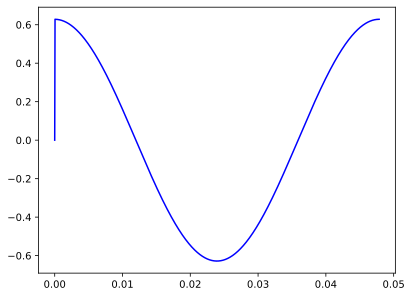

In [3]:
fig, ax = plt.subplots()
tlist_dummy = np.linspace(0,1/w_d,1000)
drive_terms[0].visualize(ax,tlist_dummy,drive_terms[0].get_pulse_shape_args_with_id())

In [4]:
def _H(t:float)->QArray:
    _H = dq.asqarray(diag_hamiltonian)
    for term in drive_terms:
        _H += dq.asqarray(term.driven_op)* term.jax_wrapper()(t, term.get_pulse_shape_args_with_id())
    return _H

H =  dq.timecallable(_H, discontinuity_ts = None)
e_ops = [qutip.ket2dm(qutip.basis(max_ql*max_ol,system.product_to_dressed[ql,ol])) for ql in range(max_ql) for ol in range(max_ol)]
c_ops = [0.022* dq.asqarray(system.a)]


In [5]:
result = dq.sesolve(
    H = H,
    psi0 = dq.asqarray(qutip.basis(max_ql*max_ol,0)),
    tsave = tlist,
    exp_ops = [dq.asqarray(e_op) for e_op in e_ops],
    method = dq.method.Tsit5(max_steps=  int(1e9),rtol=1e-11,atol=1e-11)
    )

|██████████| 100.0% ◆ elapsed 02m31s ◆ remaining 0.00ms  


In [6]:
qt_result = qutip.solver.Result()
qt_result.solver = 'dynamiqs'
qt_result.times = tlist
qt_result.expect = result.expects
qt_result.states = dq.to_qutip(result.states)
qt_result.num_expect = len(e_ops) if isinstance(e_ops, list) else 0
qt_result.num_collapse = len(c_ops) if isinstance(c_ops, list) else 0

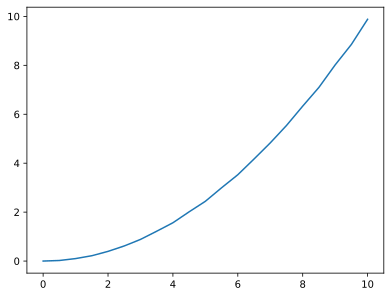

In [7]:
import numpy as np
alpha_expect = np.zeros(len(result.states),dtype=complex)
pn_expect = np.zeros(len(result.states))
for i in range(len(result.states)):
    alpha_expect[i] = qutip.expect(system.a, qt_result.states[i])
    pn_expect[i] = qutip.expect(system.a.dag()*system.a, qt_result.states[i])
plt.plot(tlist,pn_expect)
plt.show()

In [8]:
frequency_used = -1*w_d

(-0.004394391837686194,
 0.009578405631985823,
 -3.300237046964022,
 0.15071721084676484)

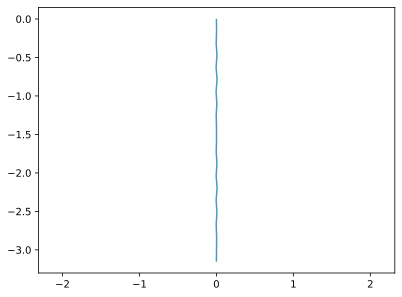

In [9]:
alpha_arr = (alpha_expect*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )
plt.plot(alpha_arr.real,alpha_arr.imag, color='#4999c3',label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
plt.axis('equal')

In [11]:
qt_result.states_in_product_basis = system.convert_dressed_to_product_vectorized(states = qt_result.states,
                                                                                products_to_keep = system.products_to_keep,
                                                                                num_processes=None,
                                                                                update_products_to_keep = False,
                                                                                show_progress=True)

Processing States: 100%|██████████| 21/21 [00:00<00:00, 22.03it/s]n_fork.py: 66


In [12]:
qubit_populations = []
for ql in range(max_ql):
    expect_traces = [qt_result.expect[ql*max_ol + ol]   # no “,:” or “.T” needed
                    for ol in range(max_ol)]

    # vertical (row‑wise) sum → 1‑D array whose length == number of time steps
    vertical_sum = np.sum(expect_traces, axis=0)
    qubit_populations.append(vertical_sum)

 /home/kai/miniconda3/envs/CQS/lib/python3.10/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /home/kai/miniconda3/envs/CQS/lib/python3.10/site-packages/matplotlib/cbook.py: 1355

Text(0, 0.5, 'population')

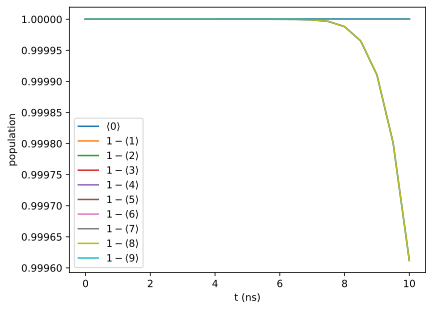

In [13]:
for ql in range(max_ql):
    if ql ==0:
        plt.plot(tlist, qubit_populations[ql],label=rf'$\langle{ql}\rangle$')
    else:
        plt.plot(tlist, 1-np.array(qubit_populations[ql]),label=rf'$1-\langle{ql}\rangle$')
plt.legend()
plt.xlabel(f"t (ns)")
plt.ylabel("population")

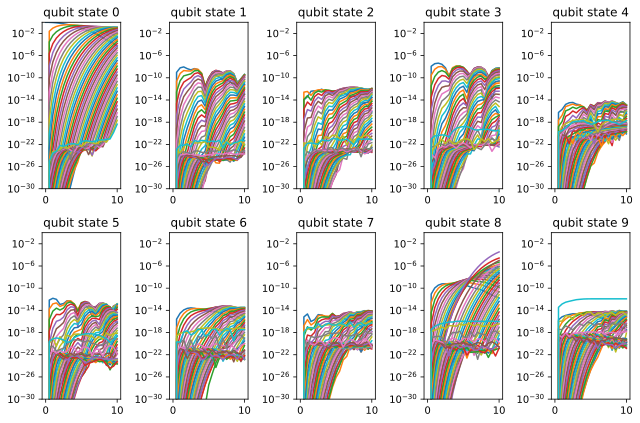

In [14]:
fig, axes = plt.subplots(2,5,figsize=(9,6))
for i, ax in enumerate(axes.flatten()):
    for ol in range(max_ol):
        ax.plot(tlist,np.abs(qt_result.expect[i*max_ol+ol]))
    ax.set_title(f'qubit state {i}')
    ax.set_ylim(1e-30,1)
    ax.set_yscale('log')
plt.tight_layout()